In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

from sat_metropolis import smt, mcmc, sat, utils

In [2]:
# Taken from (Simson Garfinkel, John M. Abowd, Christian Martindale. Understanding Database Reconstruction Attacks on Public Data. Communications of the ACM, March 2019, Vol. 62 No. 3, Pages 46-53. DOI: 10.1145/3287287)

# Assumption, all bit-vectors are of the same size
num_bits = 8
num_vars = 5*2 # (age, gender)
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)] # 0-4 age vars, 5-9 sex vars
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2], x[3], x[4]]))
g.add(sat.addition_does_not_overflow([x[5], x[6], x[7], x[8], x[9]]))
for i in range(5):
    g.add(sat.multi_does_not_overflow([x[i],x[i+5]])) # this is in case of multiplication

# these are binary (obviously only for the purpose of the example)
# FEMALE = 0
# MALE = 1
for i in range(5,10):
    g.add(ULE(0,x[i]))
    g.add(ULE(x[i],1))


# establish an order to set the median
g.add(ULE(0,x[0]))
g.add(ULE(x[0],x[1]))
g.add(ULE(x[1],x[2]))
g.add(ULE(x[2],x[3]))
g.add(ULE(x[3],x[4]))
g.add(ULE(x[4],125))

g.add(x[2] == 30) # median

g.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5) # average age

g.add(x[5] + x[6] + x[7] + x[8] + x[9] == 3) # only 3 males

g.add(x[0]*x[5] + x[1]*x[6] + x[2]*x[7] + x[3]*x[8] + x[4]*x[9] == 44*3) # average age of males

# NOTE: we might need to set an overflow constraint for the last sum.


In [ ]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='unigen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           timeout_sampler=3600,
                                           num_samples=5000,
                                           num_chains=10)

Executing Unigen sampler
c o UniGen SHA1: 0644b3314886977ee6f81bf877dd765986b69112
c o CMS SHA1: 8aa74097b5beab8d2cc11a1ee3fb5fb3911c6d13
c o Arjun SHA1: a102d0267599b3ed4c32ce4474a9072a4307bd37
c o Arjun SBVA SHA1: 6dc05afe9424bd04cd3beba50b919fde2754a637
c o ApproxMC SHA1: f604c8d2964cea1dfac6ae110034c914e2057f4c
c o Using VMTF, picosat, CaDiCaL, and CadiBack code by Armin Biere
c o CMS is MIT licensed
c o Using code from 'When Boolean Satisfiability Meets Gauss-E. in a Simplex Way'
c o       by C.-S. Han and J.-H. Roland Jiang in CAV 2012. Fixes by M. Soos
c o Using CCAnr from 'CCAnr: A Conf. Checking Based Local Search Solver [...]'
c o       by Shaowei Cai, Chuan Luo, and Kaile Su, SAT 2015
c o Using Oracle code from 'Integrating Tree Decompositions [...]'
c o       by Tuukka Korhonen and Matti Jarvisalo, CP 2021c o Using ideas by JM Lagniez, and Pierre Marquis
c o     from paper 'Improving Model Counting [..] IJCAI 2016c o executed with command line: unigen --samples 2000 --sampl

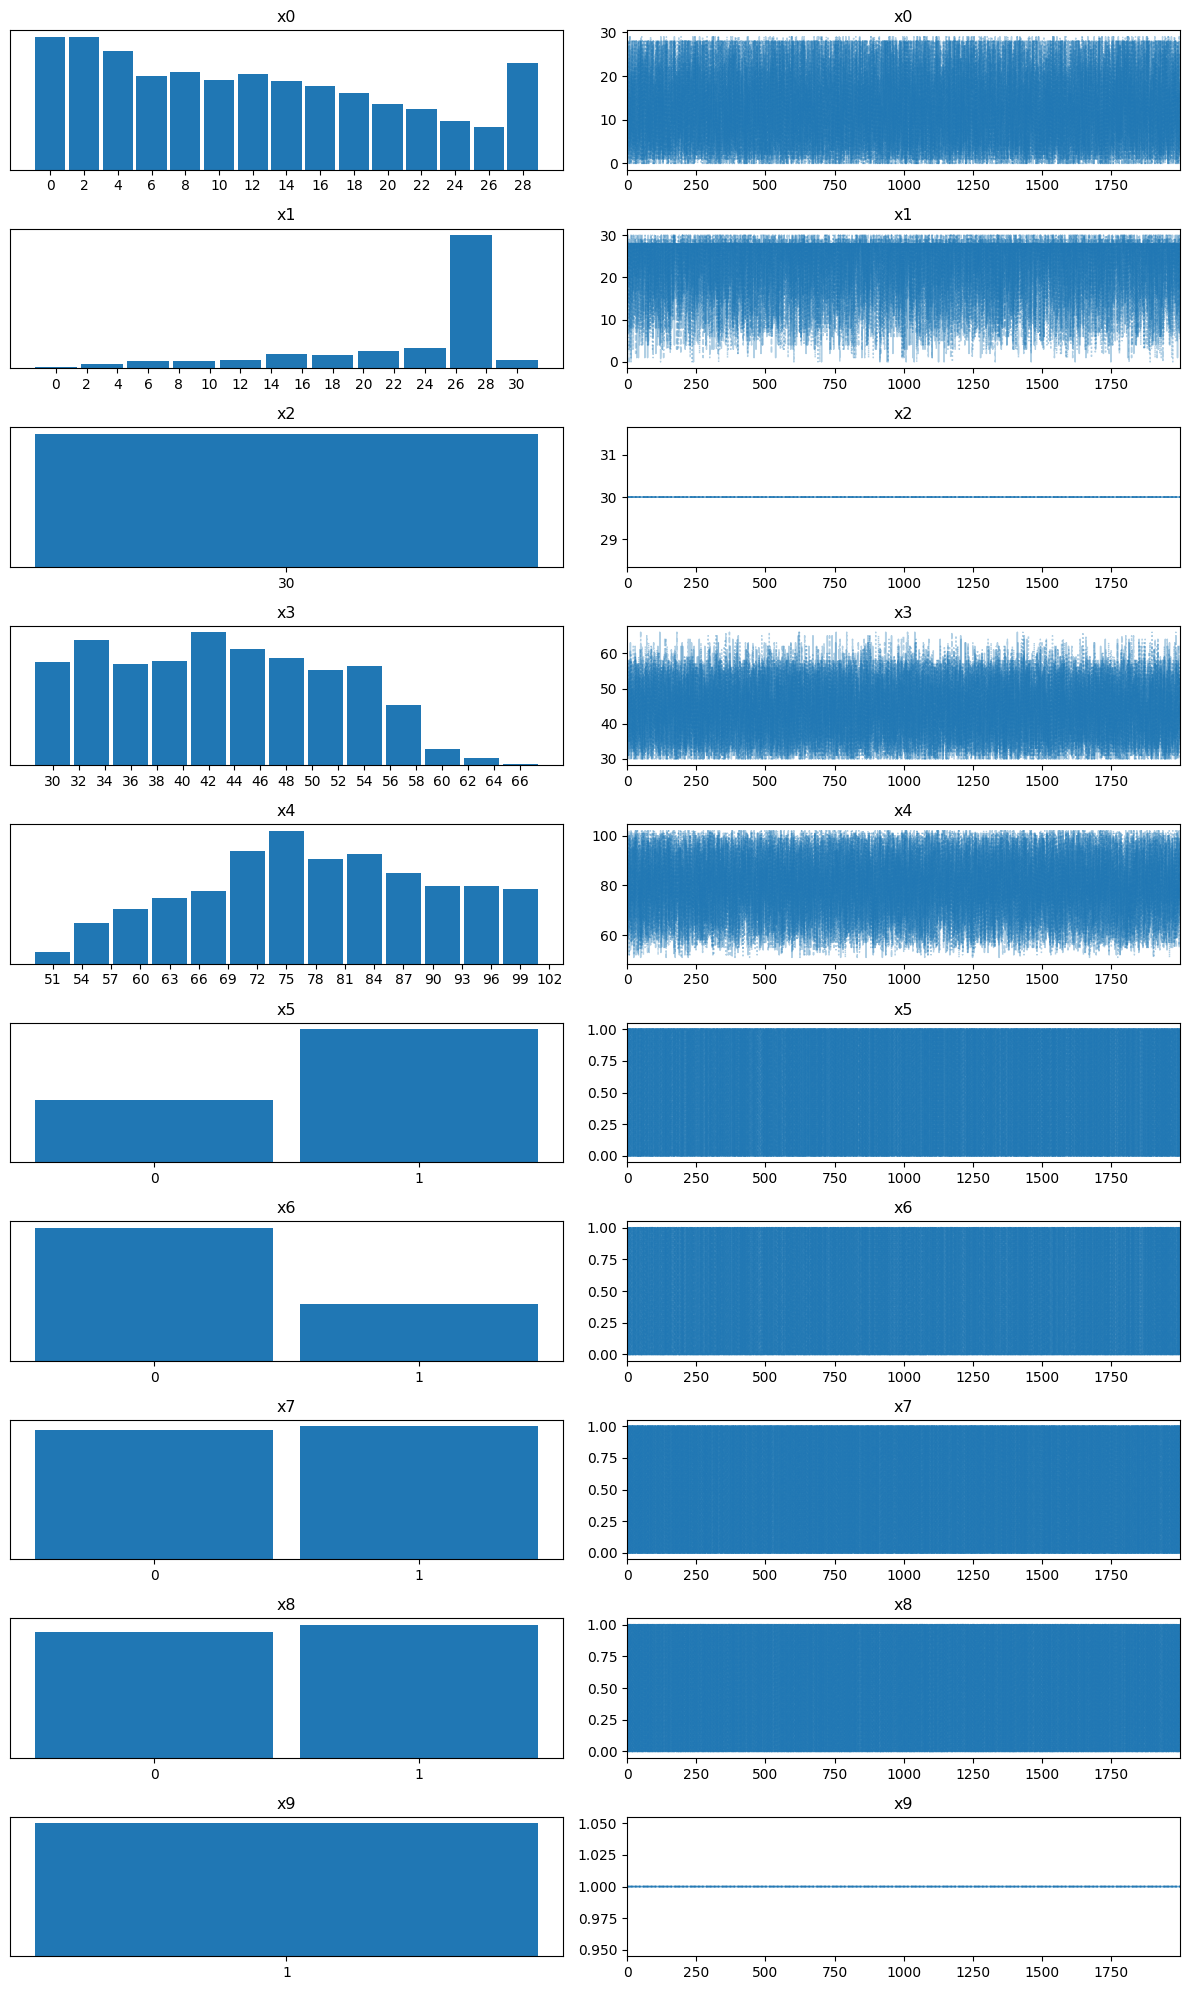

In [9]:
# Trace plot
az.plot_trace(trace);
plt.savefig('unigen_trace_plot.png', dpi=150);

In [10]:
# Diagnosis
az.summary(trace)

/home/kristoffer/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/kristoffer/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/kristoffer/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/kristoffer/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,12.476,8.723,1.0,28.0,0.063,0.030,19078.0,19444.0,1.0
x1,23.904,6.702,10.0,30.0,0.048,0.044,19779.0,19477.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,NaN,20000.0,20000.0,NaN
x3,44.026,8.530,30.0,57.0,0.060,0.031,19857.0,19709.0,1.0
x4,79.596,12.427,58.0,101.0,0.088,0.047,19796.0,19989.0,1.0
x5,0.680,0.466,0.0,1.0,0.003,0.001,20117.0,20000.0,1.0
x6,0.298,0.457,0.0,1.0,0.003,0.001,20182.0,20000.0,1.0
x7,0.507,0.500,0.0,1.0,0.004,0.000,19206.0,19206.0,1.0
x8,0.514,0.500,0.0,1.0,0.004,0.000,19322.0,19322.0,1.0
x9,1.000,0.000,1.0,1.0,0.000,NaN,20000.0,20000.0,NaN


In [ ]:
utils.save_trace(trace, f'db_cacm_SAT_unigen_{num_vars}_{num_bits}.nc')